Successfully cleaned Git markers. Working with: dirty_cafe_sales_fixed.csv


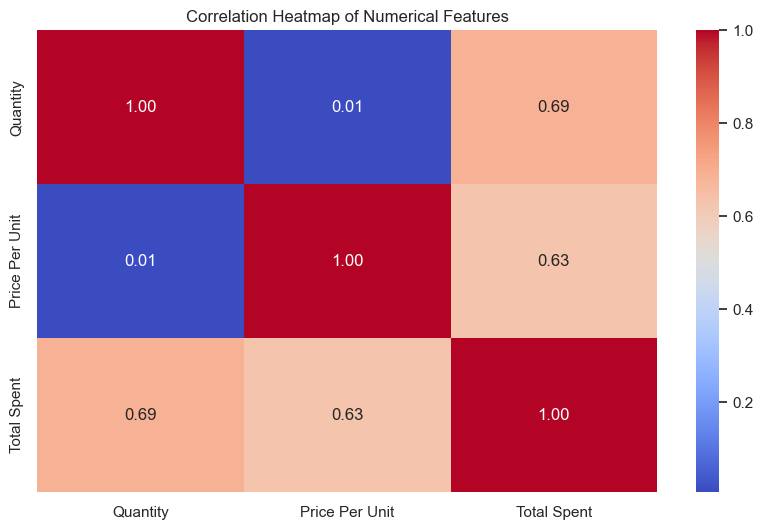

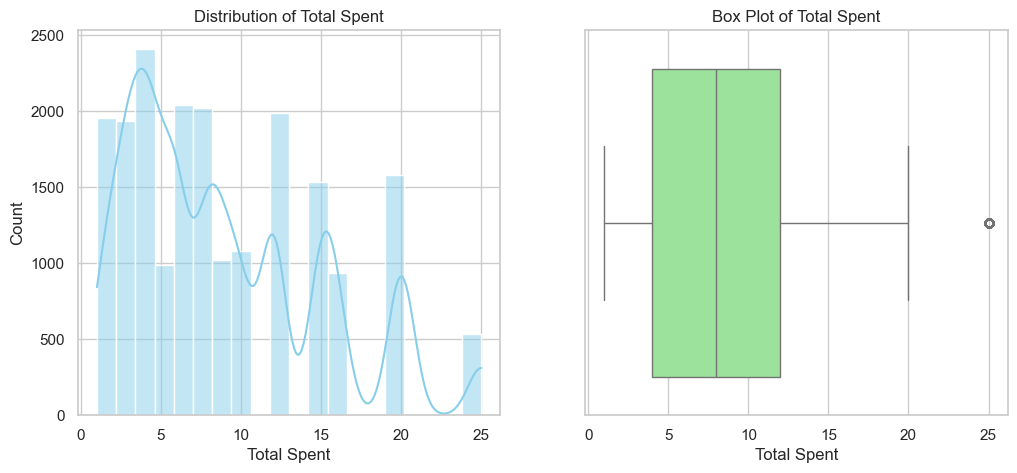

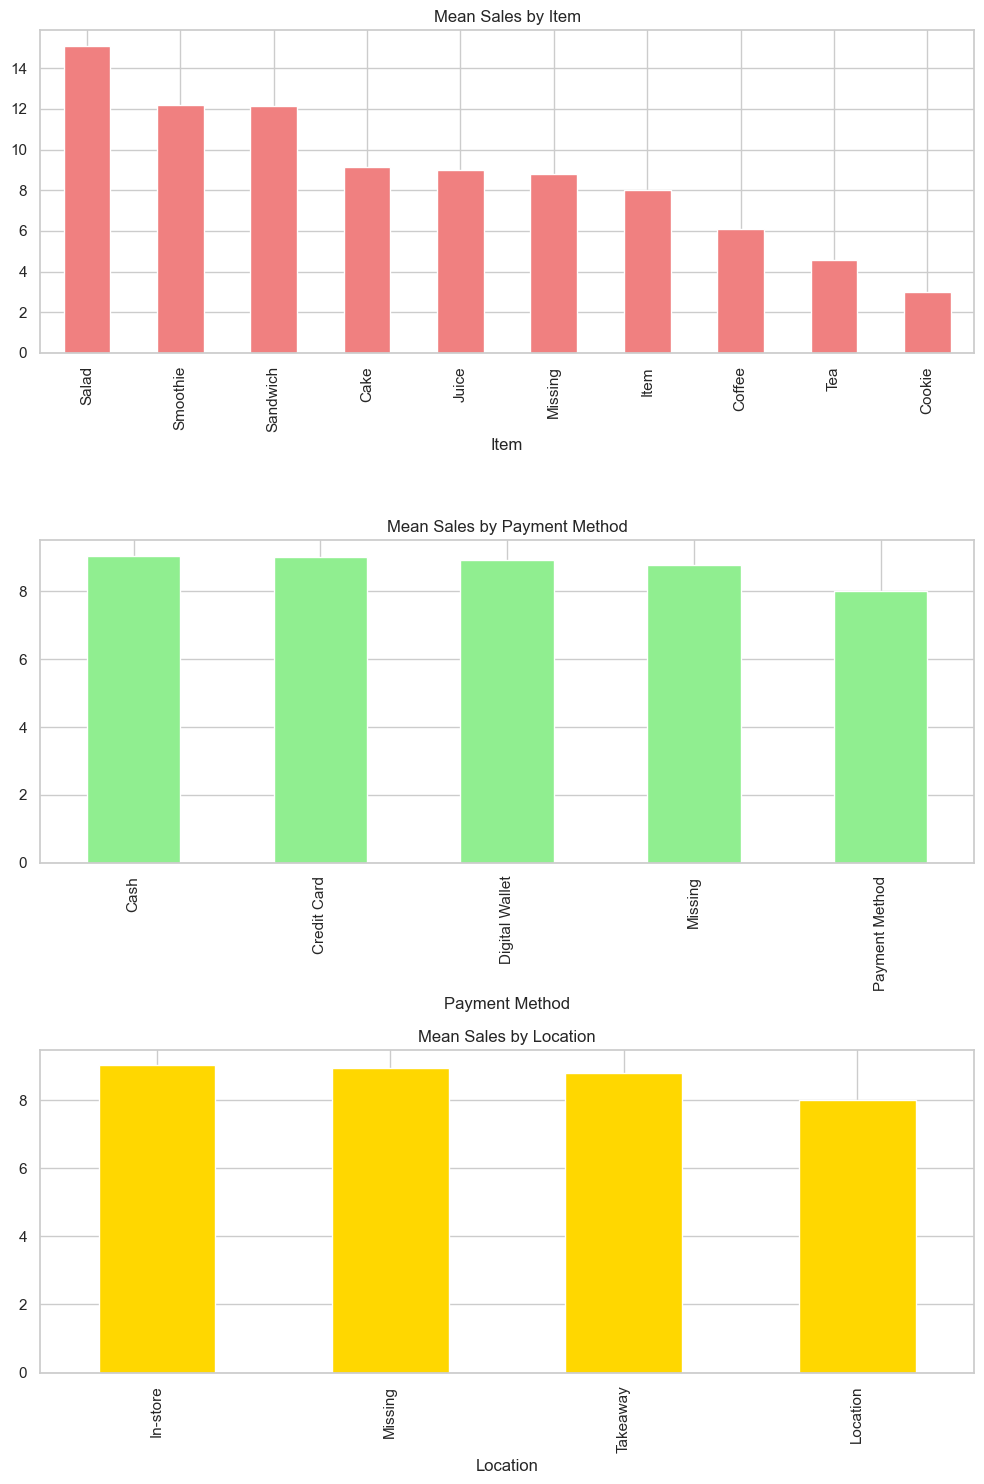

c:\Users\mohib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LR - RMSE: 2.2546
LR - MAE: 1.5854

RFR - RMSE: 1.0351
RFR - MAE: 0.2360

Final cleaned data saved as 'cleaned_cafe_sales.csv'


c:\Users\mohib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set visual style for plots
sns.set_theme(style="whitegrid")

# ==========================================
# 1. DATA RESCUE: Fix Corrupted CSV Headers
# ==========================================
# This part removes Git markers (<<<<, ====, >>>>) from the CSV file itself
input_file = 'dirty_cafe_sales.csv'
fixed_file = 'dirty_cafe_sales_fixed.csv'

try:
    with open(input_file, 'r') as f:
        lines = f.readlines()

    # Filter out lines created by Git merge conflicts
    clean_lines = [
        line for line in lines 
        if not (line.startswith('<<<<<<<') or 
                line.startswith('=======') or 
                line.startswith('>>>>>>>'))
    ]

    with open(fixed_file, 'w') as f:
        f.writelines(clean_lines)
    print(f"Successfully cleaned Git markers. Working with: {fixed_file}")
except FileNotFoundError:
    print(f"Error: {input_file} not found. Please ensure the file is in the same folder.")

# ==========================================
# 2. LOAD AND CLEAN DATA
# ==========================================
# Load the rescued dataset
df = pd.read_csv(fixed_file)

# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

df_cleaned = df.copy()

# Replace invalid entries with NaN
invalid_values = ['ERROR', 'UNKNOWN', '']
df_cleaned.replace(invalid_values, np.nan, inplace=True)

# Convert data types
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in numerical_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Convert Transaction Date to datetime
if 'Transaction Date' in df_cleaned.columns:
    df_cleaned['Transaction Date'] = pd.to_datetime(df_cleaned['Transaction Date'], errors='coerce')

# Recalculate Total Spent where missing but Quantity and Price exist
valid_calc = df_cleaned['Quantity'].notna() & df_cleaned['Price Per Unit'].notna()
df_cleaned.loc[df_cleaned['Total Spent'].isna() & valid_calc, 'Total Spent'] = \
    df_cleaned['Quantity'] * df_cleaned['Price Per Unit']

# ==========================================
# 3. IMPUTATION
# ==========================================
# Numerical Imputation (using Median)
for col in numerical_cols:
    if col in df_cleaned.columns and df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)

# Categorical Imputation (using Placeholder 'Missing')
categorical_cols = ['Item', 'Payment Method', 'Location']
for col in categorical_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna('Missing')

# Date Imputation (using Mode)
if 'Transaction Date' in df_cleaned.columns:
    mode_date = df_cleaned['Transaction Date'].mode()[0]
    df_cleaned['Transaction Date'] = df_cleaned['Transaction Date'].fillna(mode_date)

# ==========================================
# 4. FEATURE ENGINEERING
# ==========================================
# Extract time-based features
if 'Transaction Date' in df_cleaned.columns:
    df_cleaned['Transaction Month'] = df_cleaned['Transaction Date'].dt.month.astype(str)
    df_cleaned['Transaction Day'] = df_cleaned['Transaction Date'].dt.day.astype(str)
    df_cleaned['Transaction Weekday'] = df_cleaned['Transaction Date'].dt.day_name()

# Drop columns that won't be used in the model
cols_to_drop = ['Transaction ID', 'Transaction Date']
df_modeling = df_cleaned.drop(columns=[c for c in cols_to_drop if c in df_cleaned.columns])

# One-Hot Encoding for categorical variables
categorical_features = ['Item', 'Payment Method', 'Location', 'Transaction Month', 'Transaction Day', 'Transaction Weekday']
df_encoded = pd.get_dummies(df_modeling, columns=[c for c in categorical_features if c in df_modeling.columns], drop_first=False)

# Convert boolean columns to integer (1/0)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

# ==========================================
# 5. VISUALIZATIONS
# ==========================================
# --- A. Correlation Heatmap ---
plt.figure(figsize=(10, 6))
corr = df_cleaned[['Quantity', 'Price Per Unit', 'Total Spent']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# --- B. Distribution of Total Spent ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['Total Spent'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Spent')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_cleaned['Total Spent'], color='lightgreen')
plt.title('Box Plot of Total Spent')
plt.show()

# --- C. Mean Sales by Category ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

item_sales = df_cleaned.groupby('Item')['Total Spent'].mean().sort_values(ascending=False)
payment_sales = df_cleaned.groupby('Payment Method')['Total Spent'].mean().sort_values(ascending=False)
location_sales = df_cleaned.groupby('Location')['Total Spent'].mean().sort_values(ascending=False)

item_sales.plot(kind='bar', ax=axes[0], color='lightcoral', title='Mean Sales by Item')
payment_sales.plot(kind='bar', ax=axes[1], color='lightgreen', title='Mean Sales by Payment Method')
location_sales.plot(kind='bar', ax=axes[2], color='gold', title='Mean Sales by Location')

plt.tight_layout()
plt.show()

# ==========================================
# 6. MODELING
# ==========================================
# Prepare features (X) and target (y)
if 'Total Spent' in df_encoded.columns:
    X = df_encoded.drop('Total Spent', axis=1)
    y = df_encoded['Total Spent']

    # 80/20 Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Linear Regression (Baseline) ---
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print(f"LR - RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.4f}")
    print(f"LR - MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")

    # --- Random Forest Regressor ---
    rfr = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    rfr.fit(X_train, y_train)
    y_pred_rfr = rfr.predict(X_test)
    print(f"\nRFR - RMSE: {mean_squared_error(y_test, y_pred_rfr, squared=False):.4f}")
    print(f"RFR - MAE: {mean_absolute_error(y_test, y_pred_rfr):.4f}")

# Save the final cleaned data
df_cleaned.to_csv('cleaned_cafe_sales.csv', index=False)
print("\nFinal cleaned data saved as 'cleaned_cafe_sales.csv'")